In [2]:
import json
from tqdm import tqdm
import uuid
import os
from transformers import AutoProcessor, Kosmos2ForConditionalGeneration
import math
import imgviz
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
import json
from PIL import Image
import glob
from transformers import AutoProcessor

/home/omote/cluster_project/iam2/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def load_json(file_path):
    with open(file_path, "r") as f:
        data = json.load(f)
    return data

def save_json(data, file_path):
    """
    Save a Python dictionary to a JSON file.

    Parameters:
        data (dict): The data to save.
        file_path (str): The path where the JSON file will be saved.
    """
    with open(file_path, 'w', encoding='utf-8') as file:
        json.dump(data, file, ensure_ascii=False, indent=4)
        
def bbox_absolute_to_relative(absolute_bbox, image_width_height):
    width, height = image_width_height
    x1 = absolute_bbox[0] / width
    y1 = absolute_bbox[1] / height
    x2 = absolute_bbox[2] / width
    y2 = absolute_bbox[3] / height
    relative_bbox = [x1, y1, x2, y2]
    return relative_bbox

def bbox_relative_to_absolute(relative_bbox, image_width_height):
    width, height = image_width_height
    x1 = relative_bbox[0] * width
    y1 = relative_bbox[1] * height
    x2 = relative_bbox[2] * width
    y2 = relative_bbox[3] * height
    absolute_bbox = [x1, y1, x2, y2]
    return absolute_bbox

def visualize_bbox(image, bbox_list, bbox_name_list,bbox_is_relative=True,with_id=False):
    assert len(bbox_list) == len(bbox_name_list), "bbox_list and bbox_name_list must have the same length"
    if isinstance(image, str):
        image = Image.open(image).convert("RGB")

    if bbox_is_relative:
        # 画像のサイズを取得
        image_width_height = (image.width, image.height)
        # 相対座標を絶対座標に変換
        bbox_list = [bbox_relative_to_absolute(bbox, image_width_height) for bbox in bbox_list]
        
    #bbox_name_listをソート、bbox_listも同じ順番にソート
    # bbox_name_list, bbox_list = zip(*sorted(zip(bbox_name_list, bbox_list), key=lambda x: x[0]))
    # bbox_name_list = list(bbox_name_list)
    # bbox_list = list(bbox_list)
    name_to_label_id_dict = {}
    label_id = 0
    for bbox_name in bbox_name_list:
        if bbox_name not in name_to_label_id_dict:
            name_to_label_id_dict[bbox_name] = label_id
            label_id += 1    
    
    # bbox_listの座標をy1, x1, y2, x2の形式に変換
    bboxes = []
    labels = []
    # label_id = -1
    # old_label = None
    count_object_dict = {}
    id_bbox_name_list = []
    for bbox ,bbox_name in zip(bbox_list, bbox_name_list):
        x1, y1, x2, y2 = bbox
        bboxes.append([y1, x1, y2, x2])
        # if old_label != bbox_name:
        #     label_id += 1
        #     old_label = bbox_name
        label_id = name_to_label_id_dict[bbox_name]
        if bbox_name not in count_object_dict:
            count_object_dict[bbox_name] = 0
        else:
            count_object_dict[bbox_name] += 1
        if with_id:
            bbox_name = f"{bbox_name}_{count_object_dict[bbox_name]}"
            id_bbox_name_list.append(bbox_name)
        labels.append(label_id)
    # bboxes = np.array([bbox[1],bbox[0],bbox[3],bbox[2]]).astype(np.int32).reshape(-1, 4)
    
    base_resolution = 100 * 100
    base_font_size = 3
    image_resolution = image.width * image.height
    font_size = int( base_font_size * (image_resolution / base_resolution) ** 0.5)
    
    if with_id:
        bbox_name_list = id_bbox_name_list
    image = imgviz.instances2rgb(np.array(image), bboxes=bboxes, labels=labels,font_size=font_size,captions=bbox_name_list)

    plt.imshow(image)
    plt.show()

In [4]:
from pycocotools.coco import COCO
split = "train"
anno_path = f"/data_ssd/mscoco2017/coco/annotations/instances_{split}2017.json"
#/data_ssd/mscoco2017/coco/annotations/instances_train2017.json
coco_dataset = COCO(anno_path)
cat_id2name = {c["id"]: c["name"] for c in coco_dataset.loadCats(coco_dataset.getCatIds())}
object_name_list = list(cat_id2name.values())

loading annotations into memory...
Done (t=13.03s)
creating index...
index created!


In [5]:
from IPython.display import clear_output

Entity fris not in object_name_list
Entity <patch_index_422><patch_index_552> not in object_name_list
Entity the frissbee not in object_name_list
Entity the sky not in object_name_list
Entity your friends not in object_name_list
<phrase> person</phrase><object><patch_index_0194><patch_index_0906></delimiter_of_multi_objects/><patch_index_0394><patch_index_0815></delimiter_of_multi_objects/><patch_index_0431><patch_index_0884></delimiter_of_multi_objects/><patch_index_0434><patch_index_0927></object>,<phrase> fris</phrase><object><patch_index_0453><patch_index_0552></delimiter_of_multi_objects/><patch_index_0555><patch_index_0685></delimiter_of_multi_objects/><patch_index_0526><patch_index_0688></delimiter_of_multi_objects/><patch_index_0496><patch_index_0659></object>.</line>.jpg</phrase><object><patch_index_0422><patch_index_0552></object> ￼.</line> You can't see the person's face in this image, but it's obvious that they're having a good time and are about to throw<phrase> the frissb

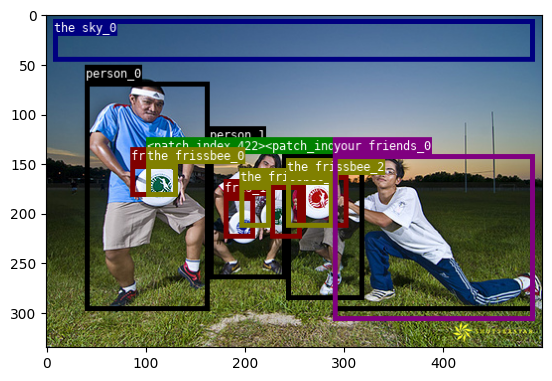

In [6]:
output_path = "/home/omote/omote-data-ssd/iam-llms-finetune/experiment_output/kosmos-2_mscoco2017-detection/mscoco2017-detection_train-vision-proj-llm_distance-forward-kl-loss_2025-07-03T16_46_51/checkpoint-16682/eval_output/test_for-kosmos2_mscoco2017-detection/max_new_tokens=320-temperature=1.0-top_p=1.0-top_k=50-num_beams=5-do_sample=False-/2025-07-14T09_54_59/eval_output.json"
json_data = load_json(output_path)
processor = AutoProcessor.from_pretrained("/data_ssd/huggingface_model_weights/microsoft/kosmos-2-patch14-224")

break_flag = False
for data in json_data:
    image_path = os.path.join("/data_ssd",data["image"])
    text = data["conversations"][1]["value"]
    processor = AutoProcessor.from_pretrained("/data_ssd/huggingface_model_weights/microsoft/kosmos-2-patch14-224")
    caption, entities = processor.post_process_generation(text)
    for entity in entities:
        if entity[0] not in object_name_list:
            print(f"Entity {entity[0]} not in object_name_list")
            break_flag = True
    if break_flag:
        caption_list = []
        bbox_list = []
        for entity in entities:
            caption_list.extend([entity[0]]*len(entity[-1]))
            bbox_list.extend(entity[-1])
        # print(bbox_list)
        print(text)
        visualize_bbox(image_path, bbox_list, caption_list, bbox_is_relative=True, with_id=True)
        break_flag = False
        x = input()
        if x == "q":
            break
        clear_output(wait=True)


<phrase> person</phrase><object><patch_index_0194><patch_index_0906></delimiter_of_multi_objects/><patch_index_0394><patch_index_0815></delimiter_of_multi_objects/><patch_index_0431><patch_index_0884></delimiter_of_multi_objects/><patch_index_0434><patch_index_0927></object>,<phrase> fris</phrase><object><patch_index_0453><patch_index_0552></delimiter_of_multi_objects/><patch_index_0555><patch_index_0685></delimiter_of_multi_objects/><patch_index_0526><patch_index_0688></delimiter_of_multi_objects/><patch_index_0496><patch_index_0659></object>.</line>.jpg</phrase><object><patch_index_0422><patch_index_0552></object> ￼.</line> You can't see the person's face in this image, but it's obvious that they're having a good time and are about to throw<phrase> the frissbee</phrase><object><patch_index_0454><patch_index_0552></delimiter_of_multi_objects/><patch_index_0524><patch_index_0654></delimiter_of_multi_objects/><patch_index_0495><patch_index_0658></object> into<phrase> the sky</phrase><object><patch_index_0000><patch_index_0159></object> 😂.</line> If you like this post, please share it with<phrase> your friends</phrase><object><patch_index_0434><patch_index_0959></object> , follow me on social media, and subscribe to my YouTube channel. Thank you for reading.. If you have any questions or comments, please don't hesitate to contact me. You can also find me on Twitter, Facebook, or Google+. Have a great day, wherever you are, whatever you're doing, I'm right there with you. See you in my next post. Until then, have a safe and enjoyable day. XOXO,.<image> Related Posts:<image><image><image> No related posts.</line> Post a Comment</line> Save my name, email, and website in this browser for the next time I comment.</line> {{#message}}{{{message}}}{{/message}} {{^message}}Your submission failed. The server responded with {{status_text}} (code {{format

In [7]:
print(data)

{'id': 'mscoco2017-detection_val-13291', 'image': 'mscoco2017/coco/images/val2017/000000013291.jpg', 'conversations': [{'from': 'human', 'value': '<image><grounding> Please carefully check the image and detect the following objects: [person, bicycle, car, motorcycle, airplane, bus, train, truck, boat, traffic light, fire hydrant, stop sign, parking meter, bench, bird, cat, dog, horse, sheep, cow, elephant, bear, zebra, giraffe, backpack, umbrella, handbag, tie, suitcase, frisbee, skis, snowboard, sports ball, kite, baseball bat, baseball glove, skateboard, surfboard, tennis racket, bottle, wine glass, cup, fork, knife, spoon, bowl, banana, apple, sandwich, orange, broccoli, carrot, hot dog, pizza, donut, cake, chair, couch, potted plant, bed, dining table, toilet, tv, laptop, mouse, remote, keyboard, cell phone, microwave, oven, toaster, sink, refrigerator, book, clock, vase, scissors, teddy bear, hair drier, toothbrush].'}, {'from': 'gpt', 'value': "<phrase> person</phrase><object><pa